In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Подключаем датасет

In [2]:
df = pd.read_excel("data.xlsx")
df.head()

,client_id,sum,status,sale,new/current,Unnamed: 5,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,NaN
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,NaN,-,-
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,NaN,оригинал,2021-07-26 00:00:00
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,2021-06-08 00:00:00


Смотрим на встречающиеся значения

In [3]:
print("status: ", df['status'].unique())
print("sale: ", df['sale'].unique())
print("new/current: ", df['new/current'].unique())
print("document: ", df['document'].unique())

status:  ['Май 2021' 'ВНУТРЕННИЙ' 'ОПЛАЧЕНО' 'ПРОСРОЧЕНО' 'Июнь 2021' 'Июль 2021'
 'Август 2021' 'В РАБОТЕ' 'Сентябрь 2021' 'Октябрь 2021' 'НА ПОДПИСАНИИ']
sale:  [nan '-' 'Петрова' 'Иванов' 'Кузнецова' 'Андреев' 'Филимонова' 'Селиванов'
 'Смирнов' 'Васильев' 'Соколов' 'Михайлов' 'Попов']
new/current:  [nan '-' 'новая' 'текущая']
document:  [nan '-' 'оригинал' 'НЕТ']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       724 non-null    float64
 1   sum             724 non-null    float64
 2   status          730 non-null    object 
 3   sale            724 non-null    object 
 4   new/current     724 non-null    object 
 5   Unnamed: 5      0 non-null      float64
 6   document        709 non-null    object 
 7   receiving_date  607 non-null    object 
dtypes: float64(3), object(5)
memory usage: 45.8+ KB


In [5]:
df = df.drop("Unnamed: 5", axis =1)

Функция для разделения данных по месяцам

In [6]:
def split_data(df:pd.DataFrame) -> dict[str,pd.DataFrame]:
  df_per_months = {}
  months_indexes = df[df["status"].str.contains("2021")].index
  months_indexes = list(months_indexes)
  months_indexes.append(len(df))

  for i, m_index in enumerate(months_indexes):
    if m_index == len(df):
      break
    m_name = df["status"].iloc[m_index]
    cur_month_idx =  m_index + 1
    next_month_idx = months_indexes[i+1]
    df_per_months[m_name] = df[cur_month_idx:next_month_idx]
  return df_per_months

In [7]:
df_per_months = split_data(df)
df_per_months

{'Май 2021':      client_id      sum      status        sale new/current  document  \
 1          6.0  11693.7  ВНУТРЕННИЙ           -           -         -   
 2         14.0   5452.7    ОПЛАЧЕНО     Петрова       новая  оригинал   
 3         15.0  13991.7    ОПЛАЧЕНО      Иванов     текущая  оригинал   
 4         16.0    719.7    ОПЛАЧЕНО      Иванов     текущая  оригинал   
 5         18.0   4253.7    ОПЛАЧЕНО      Иванов     текущая  оригинал   
 ..         ...      ...         ...         ...         ...       ...   
 124      277.0   4623.7    ОПЛАЧЕНО  Филимонова     текущая  оригинал   
 125      281.0   4488.7    ОПЛАЧЕНО   Селиванов       новая  оригинал   
 126      284.0   8903.7  ПРОСРОЧЕНО  Филимонова     текущая  оригинал   
 127      286.0   3453.7    ОПЛАЧЕНО  Филимонова     текущая  оригинал   
 128      287.0   6368.7    ОПЛАЧЕНО  Филимонова     текущая  оригинал   
 
           receiving_date  
 1                      -  
 2    2021-07-26 00:00:00  
 3    2021-06-

In [8]:
keys = list(df_per_months.keys())
months = {keys[i]:i+5 for i in range(len(keys))}
months

{'Май 2021': 5,
 'Июнь 2021': 6,
 'Июль 2021': 7,
 'Август 2021': 8,
 'Сентябрь 2021': 9,
 'Октябрь 2021': 10}

Функция для вычисления выручки за месяц

In [9]:
def month_income(df: pd.DataFrame) -> float:
  month_df = df.copy()
  month_df = month_df[month_df["status"] != "ПРОСРОЧЕНО"]
  return sum(month_df["sum"])

In [10]:
print("Выручка за Июль 2021:", round(month_income(df_per_months["Июль 2021"]), 2))

Выручка за Июль 2021: 859896.47


Функция для построения графика выручки

In [11]:
def build_income_graph(df_per_months: pd.DataFrame) -> None:
  data ={mon:df_per_months[mon].loc[(df_per_months[mon]["status"] != "ПРОСРОЧЕНО")] for mon in df_per_months}
  sum_per_month = [sum(data[mon]["sum"]) for mon in data]

  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_title('Выручка по месяцам')
  ax.bar(data.keys(),sum_per_month,color='pink')
  plt.xticks(rotation=45)
  plt.show()

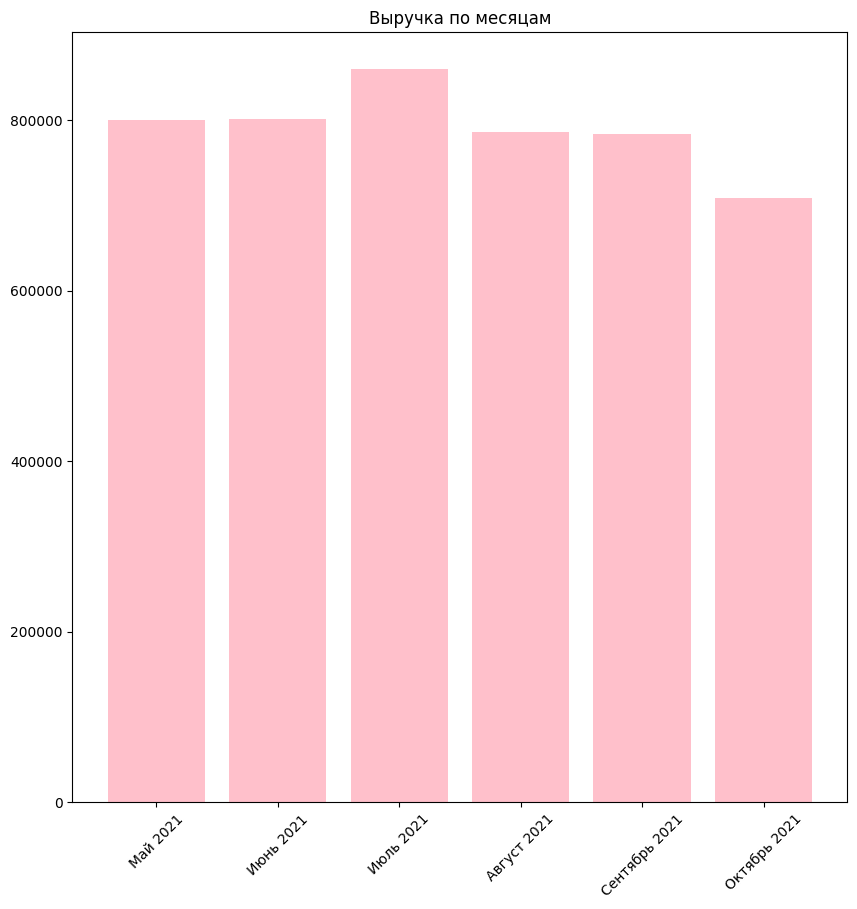

In [12]:
build_income_graph(df_per_months)

Функция для расчёта выручки от каждого менеджера

In [13]:
def income_per_manager(df: pd.DataFrame) -> dict[str, float]:
  month_df = df.copy()
  month_df = month_df.loc[(month_df["status"] != "ПРОСРОЧЕНО")]
  man_income = {man:sum(month_df.loc[month_df["sale"]== man]["sum"]) for man in month_df["sale"].unique()}
  return man_income

In [14]:
man_income = income_per_manager(df_per_months["Сентябрь 2021"])
print("Самый успешный менеджер за сентябрь:",max(man_income),round(man_income[max(man_income)],2))

Самый успешный менеджер за сентябрь: Филимонова 59514.47


Функция для рачёта количесва новых и старых сделок в месяце

In [15]:
def new_current_ratio(df: pd.DataFrame) -> dict[str, float]:
  month_df = df.copy()
  return {typ:len(month_df.loc[month_df["new/current"] == typ]) for typ in month_df["new/current"].unique()}

Преобладающий тип сделок в октябре: текущая 99


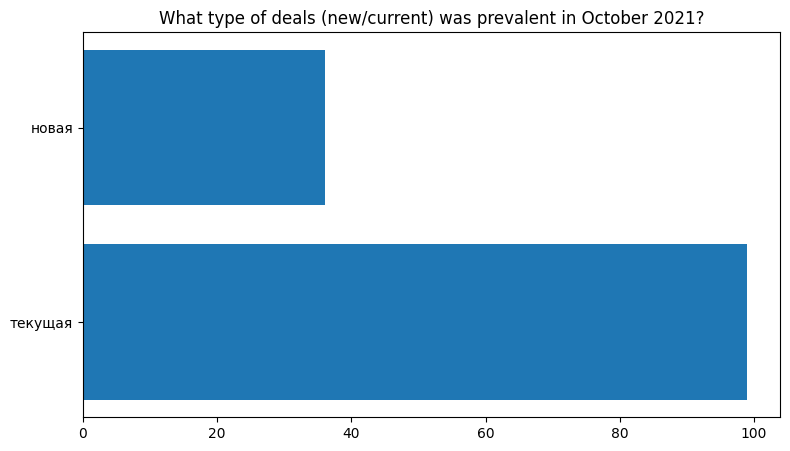

In [16]:
new_cur_rat = new_current_ratio(df_per_months["Октябрь 2021"])
print("Преобладающий тип сделок в октябре:", max(new_cur_rat),new_cur_rat[max(new_cur_rat)])

fig, ax = plt.subplots(figsize=(9, 5))
y_pos = np.arange(len(new_cur_rat))
ax.barh(y_pos, [value for (key,value) in new_cur_rat.items()], align='center')
ax.set_yticks(y_pos, labels=new_cur_rat.keys())
ax.set_title('What type of deals (new/current) was prevalent in October 2021?')
plt.show()

Функция для вычисления количества договоров по сделкам заданного, подписанных в заданном месяце

In [17]:
def get_doc_signed(df:pd.DataFrame, doc_month: int, transaction_month: str) ->pd.DataFrame:
  month_df = df[transaction_month]
  month_df = month_df[month_df["status"] != "ВНУТРЕННИЙ"]
  docs= month_df[pd.to_datetime(month_df["receiving_date"]).dt.month==doc_month]
  return docs

In [18]:
print("Количеcтво подписанных в июне договоров по майским сделкам:",len(get_doc_signed(df_per_months,months["Июнь 2021"],"Май 2021")))

Количеcтво подписанных в июне договоров по майским сделкам: 77


Функция для вычисления остатков для каждого менеджера за месяц

In [19]:
def get_month_remains(df: pd.DataFrame, month: str,remains_per_month: dict[int,float]) ->dict[int,dict[str,float]]:
  month_df = df.copy()
  month_df = month_df[month_df["status"] != "ВНУТРЕННИЙ"]
  month_df = month_df[month_df["status"] != "ПРОСРОЧЕНО"]
  month_df = month_df[pd.to_datetime(month_df["receiving_date"]).dt.month > months[month]]

  for i, row in month_df.iterrows():
    date = months[month]
    sum = 0
    if row["new/current"] == "новая" and row["status"] == "ОПЛАЧЕНО":
      sum = row["sum"] * 0.07
    elif row["new/current"] == "текущая" and row["sum"] >= 10000:
      sum = row["sum"] * 0.05
    elif row["new/current"] == "текущая" and row["sum"] < 10000:
      sum = row["sum"] * 0.03
    manager = row["sale"]
    remains_per_month[date][manager] += sum
  return remains_per_month

Функция для вычисления остатков для каждого менеджера за период

In [20]:
def get_period_remains_per_month(df_per_months: pd.DataFrame, managers:list[str]) ->dict[int,dict[str,float]]:
  remains_per_month = {i:{m:0 for m in managers} for i in range(5,11)}
  for month in df_per_months:
    get_month_remains(df_per_months[month], month, remains_per_month)
  return remains_per_month

In [21]:
remains_per_month = get_period_remains_per_month(df_per_months, df['sale'].unique()[2:])
remains_per_month

{5: {'Петрова': 8895.080000000002,
  'Иванов': 4194.918000000001,
  'Кузнецова': 3674.137699999999,
  'Андреев': 3548.7226999999993,
  'Филимонова': 969.9404999999999,
  'Селиванов': 2283.63,
  'Смирнов': 6322.216,
  'Васильев': 443.604,
  'Соколов': 0,
  'Михайлов': 0,
  'Попов': 0},
 6: {'Петрова': 8904.4694,
  'Иванов': 4300.3730000000005,
  'Кузнецова': 3427.4840000000004,
  'Андреев': 3368.2397,
  'Филимонова': 1654.0894,
  'Селиванов': 3367.3820000000005,
  'Смирнов': 5854.7390000000005,
  'Васильев': 932.6759999999999,
  'Соколов': 269.211,
  'Михайлов': 0,
  'Попов': 0},
 7: {'Петрова': 5637.0374,
  'Иванов': 6542.84,
  'Кузнецова': 4352.744,
  'Андреев': 5692.403100000001,
  'Филимонова': 5070.617000000001,
  'Селиванов': 1804.7670000000003,
  'Смирнов': 7246.5470000000005,
  'Васильев': 2559.887,
  'Соколов': 668.8420000000001,
  'Михайлов': 0,
  'Попов': 0},
 8: {'Петрова': 7304.112600000002,
  'Иванов': 4136.077,
  'Кузнецова': 2649.909,
  'Андреев': 8772.7985,
  'Филимонов

In [22]:
print("Остаток каждого из менеджеров на 01.07.2021")
for name, remains in remains_per_month[6].items():
    print(f'{name} {remains}')

Остаток каждого из менеджеров на 01.07.2021
Петрова 8904.4694
Иванов 4300.3730000000005
Кузнецова 3427.4840000000004
Андреев 3368.2397
Филимонова 1654.0894
Селиванов 3367.3820000000005
Смирнов 5854.7390000000005
Васильев 932.6759999999999
Соколов 269.211
Михайлов 0
Попов 0
